# 📌 Machine Learning for False Signal Detection in Trading


## ⚡️ Trading Signals

We apply a **Moving Average Crossover** signals, entering a **buy position when the short-term moving average crosses above the long-term moving average**, signaling upward momentum. The position is closed with a **take profit at a 6% gain** or a **stop loss at a 1.5% decline from the entry price.** This approach emphasizes **Money** and **Risk Management** by defining clear profit targets and limiting downside risk.

## 📖 Overview
This project applies **Machine Learning (ML)** to **False Signal Detection** in trading by use moving average cross over strategy. The goal is to enhance the **win rate** of a trading system by identifying **ineffective trade signals**. By leveraging **supervised learning** with models such as:

- **Decision Tree**
- **Random Forest**

The system learns from **historical trading signals**, **technical indicators**, and their **trade outcomes (profit/loss)** to detect unreliable signals that frequently lead to losses.

---

## 💲Money &  Risk Management

- **Trading Direction :** Long Bias 
- **Risk Reward Ratio :** 4 : 1 
- **Take Profit :** 6 %  Above Entry Points
- **Stop Loss :** 1.5 % Under Entry Points 
  
---

## 🎯 Objective
- Train ML models to **recognize losing trade patterns**.
- **Filter out false signals** before executing trades.
- Improve overall **trading performance and risk management**.

---

## 📊 Dataset & Features
The dataset consists of **historical data**,**technical indicators**,**input features**,**trading signals** and **trade outcomes ( target variable )**.

### 🔹 Over All:

- **Historical Data:** Open, High, Low, Close, Volume (OHLCV).
- **Technical Indicators:** Moving Averages for creating  Trading Signals
- **Trading Signals:** Buy/Sell signals generated by the system.

### **🧩 Input Features:**

-  **Compare the distance between the entry point and the short-term Moving Average at the entry points** ( Expressed as a percentage change )  

-  **Compare the distance between the entry point and the long-term Moving Average at the entry points** ( Expressed as a percentage change )  

-  **Short-term Moving Average**  at the entry points

-  **Long-term Moving Average**  at the entry points

- **Entry Price**
     
### **🎯 Target Variable:**
- **Profit/Loss Classification:** Binary output (Win ✅ or Loss ❌)

---

## 🛠️ Machine Learning Models
Three supervised learning models are implemented:

### **🌳 Decision Tree**
- A tree-based model that learns decision rules from historical trades.
- Captures non-linear relationships and interpretable decision paths.

### **🌲 Random Forest**
- An ensemble of Decision Trees to reduce overfitting.
- Improves accuracy and generalization.

---

## 🔄 Workflow
1. **Fetching Data:** Gather market data trading signals, technical indicators, and trade results.**
   - Fetch Historical Data.
   - Calculate Exponentail Moving Average. ( Trading Indicator )
   - Create Trading Signals.
2. **Backtest Trading Strategy:**
   - Backtest Trading signals performance with vectorbt.
   - Observe trading journals to evaluate trading history & performance.
     
3. **Feature Engineering:**
   - Incorporate trading journal (Trading History)
   - Create Specific Indicators for Machine Learning Models
   - Use the Specific Indicators with trading signals at each time period along with the trade outcomes (Profit or Loss) to construct a new table for Feature Engineering before training Machine Learning models.

5. **Data Manipulation & Pre-Processing ( for Machine Learning Models ):**
   - Split data into training & testing sets as a time series method.
   - Use the DecisionTree model to identify parameters that yield the highest Precision and F1 Score, respectively. These parameters are used to improve trading quality by using machine learning to filter profit/loss buy points and the corresponding sell points, based on historical data (excluding unseen data).

6. **Model Creation:**
   - Train DecisionTree and RandomForest models with training set.
   - Assume that every model can detect profit and loss, and is ready to predict on unseen data.
     
7. **Fowardtest with unseen data ( test set ) :**
   - Backtest the technical analysis indicators using the same period of unseen data.
   - Make predictions using machine learning models on unseen data (test set).
   - Develop rules to filter out unreliable trade signals from machine learning models.
     
9. **Trading Performance Evaluation:**
   - Evaluate the trading performance on unseen data using technical indicators, decision tree and random forest and compare the results with the buy & hold strategy and benchmark.

---

## 📊 Performance Metrics
- **Precision**: Measures the proportion of correctly identified winning trades.
- **F1-Score**: Balances precision and recall.
- **Confusion Matrix**: Visualizes classification performance.

---

## 📌 Expected Outcome
✅ **Reduced False Trades:** Fewer trades based on unreliable signals.  
✅ **Improved Trading Win Rate:** More profitable trades and reduced unnecessary losses.  
✅ **Better Risk Management:** Avoiding bad trades reduces exposure to losses.  

---

## 🚀 Future Enhancements
🔹 Experiment with technical indicators, fundamental data, economic data, and other news data as well.
🔹 Incorporate **Deep Learning (LSTM, CNN)** for pattern recognition.  
🔹 Implement **Deep Reinforcement Learning** for strategy optimization.  
🔹 Experiment with additional **Feature Selection Techniques**.  

---

## 📜 Conclusion
By applying **Machine Learning to trading signals**, this project aims to enhance trading performance by filtering out **false signals**. The insights gained will contribute to **data-driven decision-making** and ultimately **higher profitability** in algorithmic trading.


<br>

<br>

<br>


### Import Libary

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta


import time
from IPython.display import clear_output

import matplotlib.pyplot as plt
import plotly.graph_objs as go


from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, f1_score


import yfinance as yf
import pandas_ta as ta
import vectorbt as vbt

import warnings
warnings.filterwarnings('ignore')

<br>

<br>

### Building Necessary Function

##### Visualizasion Asset Compound Return

In [2]:
def visualizasion_portfolio_compound_return(port,label='',color='#3987b3'):
    port_value = port.value()
    port_compound_return = (port_value  / port_value.iloc[0]) - 1   #Calculate Compound Return of Trading Strategy
    
    index = port_compound_return.index
    value = port_compound_return.values

    # Visualizasion
    plt.figure(figsize=(10, 4))
    plt.plot(index, value*100, label=label,color=color)
    plt.show()

    return index ,value

##### Optimal Decision Tree for False Signal Detection

In [3]:
def optimal_tree_gain_profit_signals(X, y, X_train, y_train):

    results = []
    best_clf = None  # To store the best model
    
    # Define parameter grid
    param_grid = {
        'min_samples_leaf': [3,4,5,6,7,8,9,11,13,15,17,19,21,24,27,30],
        'max_depth': [3, 5, 10, 15, 20],
        'min_samples_split': [2, 5, 10],
        'criterion': ['gini', 'entropy']
    }
    
    # Create and fit GridSearchCV
    clf = tree.DecisionTreeClassifier(class_weight='balanced')
    grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='precision')
    grid_search.fit(X_train, y_train)
    
    # Process all results
    for params, mean_score in zip(grid_search.cv_results_['params'], 
                                 grid_search.cv_results_['mean_test_score']):
        # Create model with these parameters
        clf = tree.DecisionTreeClassifier(class_weight='balanced', **params)
        clf.fit(X_train, y_train)
        
        all_predict = clf.predict(X)
        
        precision = precision_score(y, all_predict, average='binary')
        f1 = f1_score(y, all_predict, average='binary')
        
        results.append({
            'min_samples_leaf': params['min_samples_leaf'],
            'max_depth': params['max_depth'],
            'min_samples_split': params['min_samples_split'],
            'criterion': params['criterion'],
            'Precision': precision,
            'F1 Score': f1,
        })
        
        # Store the best model
        if best_clf is None or precision > max([r['Precision'] for r in results][:-1], default=0):
            best_clf = clf
    
    results_df = pd.DataFrame(results)
    
    # Sort by Precision and F1 Score
    results_df = results_df.sort_values(by=['Precision', 'F1 Score'], ascending=False)
    
    display(results_df.head(10))
    print("\n"*5)
    
    # Plot Decision Tree of the best model
    plt.figure(figsize=(15, 7))
    tree.plot_tree(best_clf, feature_names=X.columns, class_names=['Loss', 'Profit'], filled=True)
    plt.show()
    
    return results_df

<br>

<br>

### Fetching Data

##### Initail Parameter

In [4]:
symbol = "NVDA"
interval = '1h'
periods = '2y'     

##### Fetch Historical Data

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Datetime,,,,,
2023-04-18 13:30:00+00:00,27.698999,28.110001,27.570999,27.575001,23141747
2023-04-18 14:30:00+00:00,27.896999,27.960999,27.620001,27.695002,9110771
2023-04-18 15:30:00+00:00,27.930271,27.939001,27.728008,27.896999,6094656
2023-04-18 16:30:00+00:00,27.790100,27.945002,27.776011,27.931000,4328122
2023-04-18 17:30:00+00:00,27.584499,27.858999,27.501001,27.789001,5847270
...,...,...,...,...,...
2025-04-17 15:30:00+00:00,101.235001,101.400002,100.160004,100.394997,34589269
2025-04-17 16:30:00+00:00,100.831200,101.839996,100.751701,101.235100,26631436
2025-04-17 17:30:00+00:00,102.156303,102.379997,100.790001,100.839996,26656995


<Axes: xlabel='Datetime'>

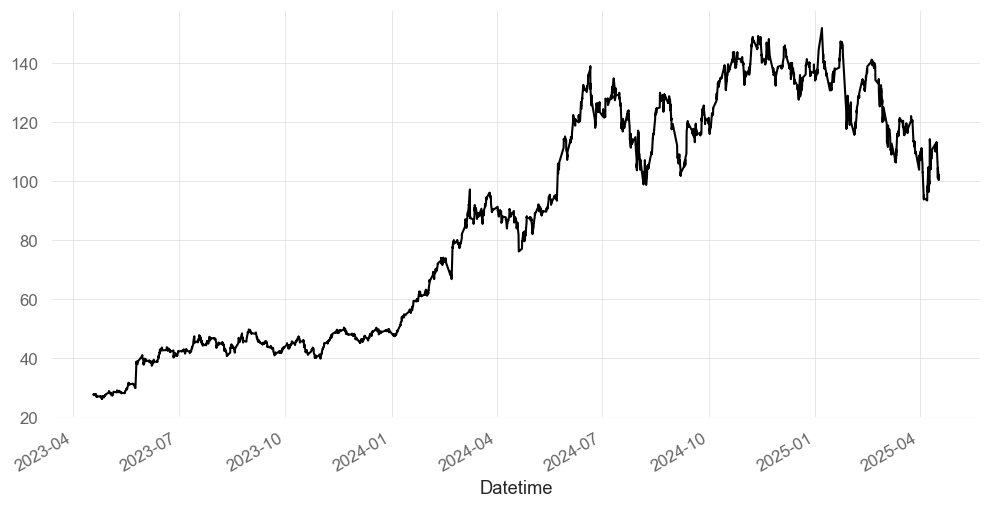

In [5]:
data = yf.download(symbol,interval=interval,period=periods)
df = data.copy()
df.columns = df.columns.droplevel(1)
display(df)
df.Close.plot(figsize=(12, 6),color=['black'])

<br>

<br>

<br>

### Create Technical Indicator

##### Initail Parameter

In [6]:
fast_ma = 10
slow_ma = 20

##### Calculate Indicator

Price,Close,High,Low,Open,Volume,fast_ma,slow_ma
Datetime,,,,,,,
2025-04-17 15:30:00+00:00,101.235001,101.400002,100.160004,100.394997,34589269,103.341124,105.455826
2025-04-17 16:30:00+00:00,100.831200,101.839996,100.751701,101.235100,26631436,102.884774,105.015385
2025-04-17 17:30:00+00:00,102.156303,102.379997,100.790001,100.839996,26656995,102.752325,104.743092
2025-04-17 18:30:00+00:00,101.214996,102.489998,101.019997,102.160004,27771508,102.472810,104.407083
2025-04-17 19:30:00+00:00,101.410004,101.699997,100.849998,101.209999,22752612,102.279573,104.121647


<Axes: xlabel='Datetime'>

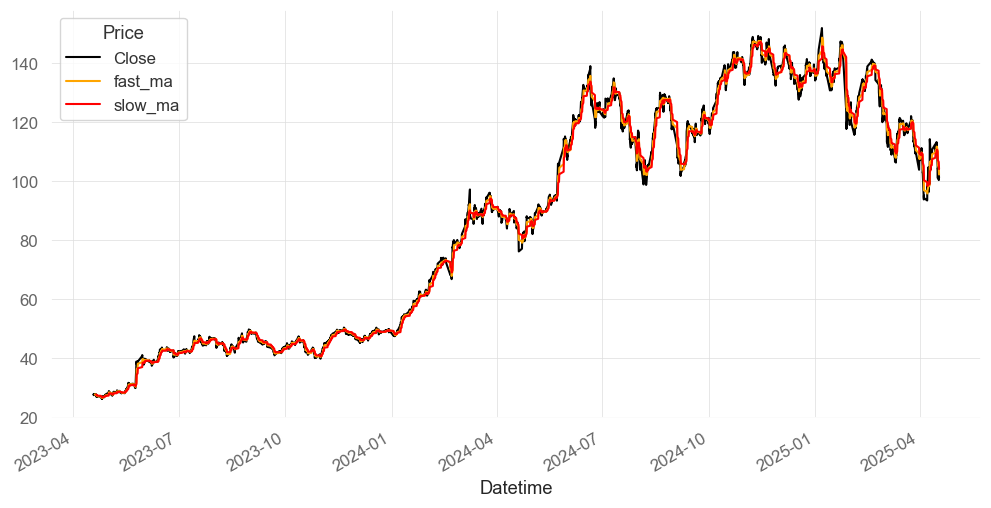

In [7]:
df['fast_ma'] =  ta.ema(close=df['Close'],length= fast_ma)
df['slow_ma'] = ta.ema(close=df['Close'],length= slow_ma)
display(df.tail())
df[['Close','fast_ma','slow_ma']].plot(figsize=(12, 6),color=['black','orange','red'])

<br>

<br>

<br>

### Backtest Trading Strategy

##### Make Decision Signal

In [8]:
df_signal = pd.DataFrame(index=df.index)
df_signal['Long_Entry'] = df['fast_ma'] > df['slow_ma']

df_signal.Long_Entry = df_signal.Long_Entry.shift(1).fillna(False)

##### Backtest

In [9]:
port = vbt.Portfolio.from_signals(open=df.Open,
                                  high=df.High,
                                  low=df.Low,
                                  close=df.Close,
                                  entries=df_signal['Long_Entry'], # Buy-Side Entry
                                  direction='longonly',
                                  init_cash=1000,
                                  fees=0.001,
                                  tp_stop=0.06,
                                  sl_stop=0.015
                                 )
original_signal_stats = pd.DataFrame(port.stats(),columns=['Original Signal Stats'])
display(original_signal_stats)

,Original Signal Stats
Start,2023-04-18 13:30:00+00:00
End,2025-04-17 19:30:00+00:00
Period,3501
Start Value,1000.0
End Value,1591.345539
Total Return [%],59.134554
Benchmark Return [%],266.114321
Max Gross Exposure [%],100.0
Total Fees Paid,589.752711
Max Drawdown [%],35.453281


<br>

#### Visualizasion Trading Strategy Compound Return

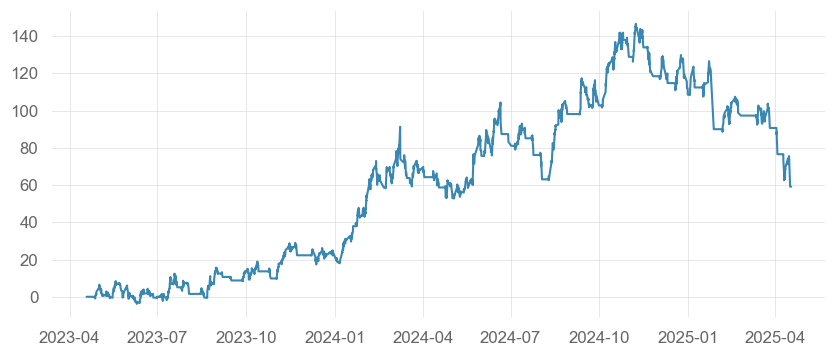

In [10]:
index ,value = visualizasion_portfolio_compound_return(port,label='All signal from Technical Analysis',color='#3987b3')

<br>

<br>

<br>

### Feature Engineering 



<br>

#### Trading Journals 

In [11]:
trades = port.trades.records_readable

# Get Moving Average values from Entry Points
trades['Fast_MA_Entry'] = df['fast_ma'].reindex(trades['Entry Timestamp']).values
trades['Slow_MA_Entry'] = df['slow_ma'].reindex(trades['Entry Timestamp']).values

trades['Fast_MA_pct_change_from_Entry'] = trades['Fast_MA_Entry'] / trades['Avg Entry Price'] -1
trades['Slow_MA_pct_change_from_Entry'] = trades['Slow_MA_Entry'] / trades['Avg Entry Price'] -1

# Calculate 'ProfitFromSignals' after the MA columns are added
trades['ProfitFromSignals'] = np.sign(trades['Return'])

# Display the updated trades DataFrame
display(trades.head(5))

,Exit Trade Id,Column,Size,Entry Timestamp,Avg Entry Price,Entry Fees,Exit Timestamp,Avg Exit Price,Exit Fees,PnL,Return,Direction,Status,Position Id,Fast_MA_Entry,Slow_MA_Entry,Fast_MA_pct_change_from_Entry,Slow_MA_pct_change_from_Entry,ProfitFromSignals
0,0,0,37.006889,2023-04-26 18:30:00+00:00,26.995001,0.999001,2023-05-01 14:30:00+00:00,28.614701,1.058941,57.882118,0.057940,Long,Closed,0,26.951780,26.944140,-0.001601,-0.001884,1.0
1,1,0,36.848844,2023-05-01 15:30:00+00:00,28.680012,1.056825,2023-05-02 14:30:00+00:00,28.249812,1.040973,-17.950178,-0.016985,Long,Closed,1,27.945378,27.603966,-0.025615,-0.037519,-1.0
2,2,0,36.880721,2023-05-02 15:30:00+00:00,28.169001,1.038893,2023-05-03 13:30:00+00:00,27.746466,1.023310,-17.645598,-0.016985,Long,Closed,2,28.378508,28.093247,0.007438,-0.002689,-1.0
3,3,0,36.761278,2023-05-03 14:30:00+00:00,27.781000,1.021265,2023-05-04 16:30:00+00:00,27.364285,1.005946,-17.346187,-0.016985,Long,Closed,3,28.146430,28.088404,0.013154,0.011065,-1.0
4,4,0,35.277823,2023-05-05 16:30:00+00:00,28.457998,1.003936,2023-05-17 19:30:00+00:00,30.165478,1.064172,58.168064,0.057940,Long,Closed,4,28.062138,27.982701,-0.013910,-0.016702,1.0


<br>

<br>

<br>


<br>

##### Assign Entry & Exit Timestamp

In [12]:
entry_ts = trades[['Entry Timestamp']]
exit_ts = trades[['Exit Timestamp']]

<br>

##### Calculate Split Test Set index ( Time Series )

In [13]:
pct_split = 70
start_test_position = int(len(trades)*pct_split/100)
print('Percentage :',pct_split,' %')
print('Start Index :',start_test_position)

Percentage : 70  %
Start Index : 126


<br>

<br>

#### Separate feature variables from target variables

In [14]:
X = trades[['Avg Entry Price','Fast_MA_Entry','Slow_MA_Entry','Fast_MA_pct_change_from_Entry','Slow_MA_pct_change_from_Entry']]
y = trades[['ProfitFromSignals']]

In [15]:
display(X.tail())

,Avg Entry Price,Fast_MA_Entry,Slow_MA_Entry,Fast_MA_pct_change_from_Entry,Slow_MA_pct_change_from_Entry
176,107.894997,106.872382,104.169864,-0.009478,-0.034526
177,106.470001,106.379364,104.378596,-0.000851,-0.019643
178,111.333504,110.042568,108.270835,-0.011595,-0.027509
179,110.440002,110.112959,108.629006,-0.002961,-0.016398
180,105.175102,109.621187,109.725364,0.042273,0.043264


In [16]:
display(y.tail())

,ProfitFromSignals
176,-1.0
177,1.0
178,-1.0
179,-1.0
180,-1.0


<br>


#### Split data into training & testing sets as a time series method.
To Ensure that Machine Learning Models can test with Actually Unseen Data

In [17]:
X_train = X.iloc[:start_test_position]
X_test = X.iloc[start_test_position:]
y_train = y.iloc[:start_test_position]
y_test = y.iloc[start_test_position:]

<br>

<br>

<br>

#### Find Optimal min_samples_leaf of Decision Tree

,min_samples_leaf,max_depth,min_samples_split,criterion,Precision,F1 Score
388,4,15,5,entropy,0.585714,0.677686
435,4,20,2,entropy,0.585714,0.677686
436,4,20,5,entropy,0.579710,0.666667
433,3,20,5,entropy,0.573333,0.682540
385,3,15,5,entropy,0.571429,0.661157
195,4,20,2,gini,0.571429,0.631579
387,4,15,2,entropy,0.567164,0.644068
147,4,15,2,gini,0.562500,0.626087
148,4,15,5,gini,0.562500,0.626087
196,4,20,5,gini,0.562500,0.626087


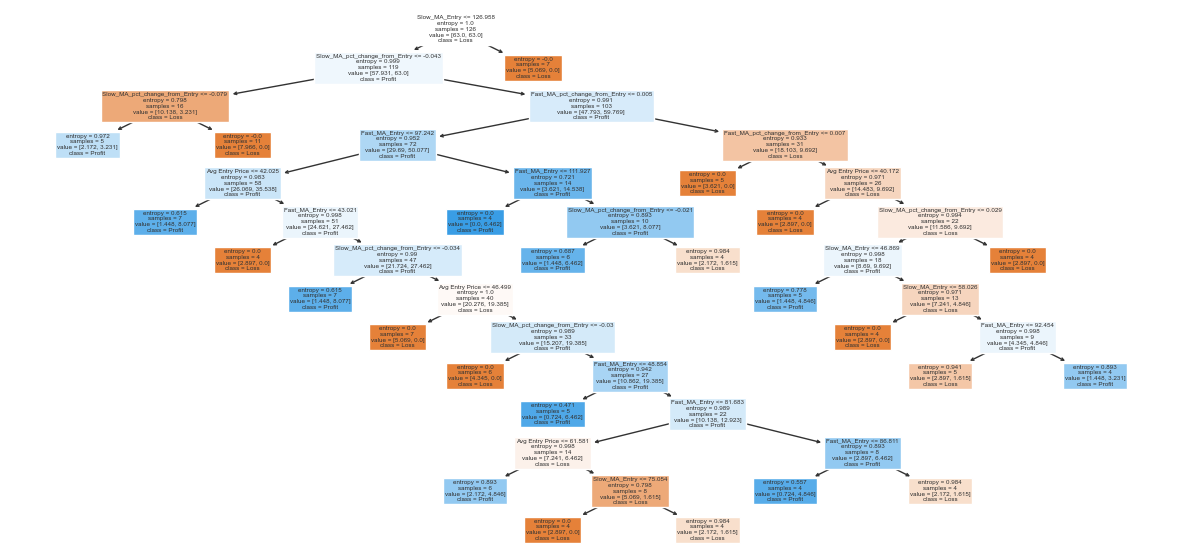

In [18]:
# Call the function
optimal_tree_results = optimal_tree_gain_profit_signals(X, y, X_train, y_train)

<br>

<br>

#### Best min sample for each leaf 

In [19]:
best_min_simples_leaf = optimal_tree_results[['min_samples_leaf','max_depth','min_samples_split','criterion']].iloc[0].to_dict()
print(f'Optimal Precision Score in Training Set is {best_min_simples_leaf}')

Optimal Precision Score in Training Set is {'min_samples_leaf': 4, 'max_depth': 15, 'min_samples_split': 5, 'criterion': 'entropy'}


<br>

<br>

<br>

<br>

### Model Creation

<br>


#### Decision Tree

In [20]:
dt = tree.DecisionTreeClassifier(class_weight='balanced', min_samples_leaf=best_min_simples_leaf['min_samples_leaf'] , max_depth= best_min_simples_leaf['max_depth'] , min_samples_split= best_min_simples_leaf['min_samples_split'] , criterion= best_min_simples_leaf['criterion'])
dt = dt.fit(X_train, y_train)

#### Random Forest

In [21]:
rf = RandomForestClassifier(class_weight='balanced', min_samples_leaf=best_min_simples_leaf['min_samples_leaf'] , max_depth= best_min_simples_leaf['max_depth'] , min_samples_split= best_min_simples_leaf['min_samples_split'] , criterion= best_min_simples_leaf['criterion'], n_estimators=100)
rf = rf.fit(X_train,y_train)

<br>

<br>

<br>


### Fowardtest with unseen data ( Test set )

##### Get Trade Logs

##### Independent Variable

In [22]:
X_test.index = trades.loc[X_test.index, 'Entry Timestamp']
display(X_test.head())

,Avg Entry Price,Fast_MA_Entry,Slow_MA_Entry,Fast_MA_pct_change_from_Entry,Slow_MA_pct_change_from_Entry
Entry Timestamp,,,,,
2024-08-26 14:30:00+00:00,127.070000,127.679859,127.438945,0.004799,0.002903
2024-08-27 15:30:00+00:00,127.974998,127.371720,127.294333,-0.004714,-0.005319
2024-09-10 18:30:00+00:00,107.549896,106.393441,106.252997,-0.010753,-0.012059
2024-09-11 18:30:00+00:00,115.980003,111.528674,109.478138,-0.038380,-0.056060
2024-09-19 15:30:00+00:00,119.160004,117.073418,116.633663,-0.017511,-0.021201


##### Target Variable

In [23]:
y_test.index = trades.loc[y_test.index, 'Entry Timestamp']
display(y_test.head())

,ProfitFromSignals
Entry Timestamp,
2024-08-26 14:30:00+00:00,-1.0
2024-08-27 15:30:00+00:00,-1.0
2024-09-10 18:30:00+00:00,1.0
2024-09-11 18:30:00+00:00,-1.0
2024-09-19 15:30:00+00:00,-1.0


<br>

##### Filter the dates in the main DataFrame  ( match the dates in the Test Set )

In [24]:
# Get the index value of the first row in X_test
start_index_value = X_test.index[0]

# Find the position of that index in df
start_index_pos = df.index.get_loc(start_index_value)

# Create a new DataFrame starting from the previous row
df_test = df.iloc[start_index_pos-1:]

# Display the new DataFrame
display(df_test)

Price,Close,High,Low,Open,Volume,fast_ma,slow_ma
Datetime,,,,,,,
2024-08-26 13:30:00+00:00,126.845001,131.259995,126.660004,129.600006,103393486,127.815383,127.477781
2024-08-26 14:30:00+00:00,127.070000,127.349998,124.370003,126.839996,62728675,127.679859,127.438945
2024-08-26 15:30:00+00:00,127.035004,127.440002,125.930000,127.059998,32422470,127.562612,127.400474
2024-08-26 16:30:00+00:00,126.489998,127.540001,126.089996,127.025002,28331944,127.367591,127.313762
2024-08-26 17:30:00+00:00,126.589996,126.680000,125.550003,126.489998,27701959,127.226211,127.244832
...,...,...,...,...,...,...,...
2025-04-17 15:30:00+00:00,101.235001,101.400002,100.160004,100.394997,34589269,103.341124,105.455826
2025-04-17 16:30:00+00:00,100.831200,101.839996,100.751701,101.235100,26631436,102.884774,105.015385
2025-04-17 17:30:00+00:00,102.156303,102.379997,100.790001,100.839996,26656995,102.752325,104.743092


<br>

<br>


#### Predict the Unseen data

In [25]:
print('X_Test Index == y_test Index  :',(X_test.index == y_test.index).all(),'\n\n')

# Make predictions
y_pred_dt = dt.predict(X_test)
y_pred_dt = pd.DataFrame(y_pred_dt, columns=["ML_Signal_DT"], index=X_test.index)


y_pred_rf = rf.predict(X_test)
y_pred_rf = pd.DataFrame(y_pred_rf, columns=["ML_Signal_RF"], index=X_test.index)

# Combine the results
combined_df = pd.concat([X_test, y_test, y_pred_dt, y_pred_rf], axis=1)
display(combined_df)

X_Test Index == y_test Index  : True 




,Avg Entry Price,Fast_MA_Entry,Slow_MA_Entry,Fast_MA_pct_change_from_Entry,Slow_MA_pct_change_from_Entry,ProfitFromSignals,ML_Signal_DT,ML_Signal_RF
Entry Timestamp,,,,,,,,
2024-08-26 14:30:00+00:00,127.070000,127.679859,127.438945,0.004799,0.002903,-1.0,-1.0,-1.0
2024-08-27 15:30:00+00:00,127.974998,127.371720,127.294333,-0.004714,-0.005319,-1.0,-1.0,-1.0
2024-09-10 18:30:00+00:00,107.549896,106.393441,106.252997,-0.010753,-0.012059,1.0,1.0,1.0
2024-09-11 18:30:00+00:00,115.980003,111.528674,109.478138,-0.038380,-0.056060,-1.0,-1.0,-1.0
2024-09-19 15:30:00+00:00,119.160004,117.073418,116.633663,-0.017511,-0.021201,-1.0,-1.0,-1.0
2024-09-20 14:30:00+00:00,115.739998,117.377519,117.122724,0.014148,0.011947,1.0,1.0,-1.0
2024-09-25 14:30:00+00:00,124.025200,120.917753,119.319537,-0.025055,-0.037941,-1.0,1.0,1.0
2024-09-26 15:30:00+00:00,123.421700,123.232834,121.786042,-0.001530,-0.013253,-1.0,-1.0,1.0
2024-09-27 14:30:00+00:00,120.254997,122.622668,122.134876,0.019689,0.015632,-1.0,-1.0,-1.0


<br>

<br>

#### Reattach the indicators and trading signals to the DataFrame.

In [26]:
df_test = pd.concat([df_test, combined_df['ML_Signal_DT'],combined_df['ML_Signal_RF']], axis=1)
display(df_test)

,Close,High,Low,Open,Volume,fast_ma,slow_ma,ML_Signal_DT,ML_Signal_RF
2024-08-26 13:30:00+00:00,126.845001,131.259995,126.660004,129.600006,103393486,127.815383,127.477781,NaN,NaN
2024-08-26 14:30:00+00:00,127.070000,127.349998,124.370003,126.839996,62728675,127.679859,127.438945,-1.0,-1.0
2024-08-26 15:30:00+00:00,127.035004,127.440002,125.930000,127.059998,32422470,127.562612,127.400474,NaN,NaN
2024-08-26 16:30:00+00:00,126.489998,127.540001,126.089996,127.025002,28331944,127.367591,127.313762,NaN,NaN
2024-08-26 17:30:00+00:00,126.589996,126.680000,125.550003,126.489998,27701959,127.226211,127.244832,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2025-04-17 15:30:00+00:00,101.235001,101.400002,100.160004,100.394997,34589269,103.341124,105.455826,NaN,NaN
2025-04-17 16:30:00+00:00,100.831200,101.839996,100.751701,101.235100,26631436,102.884774,105.015385,NaN,NaN
2025-04-17 17:30:00+00:00,102.156303,102.379997,100.790001,100.839996,26656995,102.752325,104.743092,NaN,NaN
2025-04-17 18:30:00+00:00,101.214996,102.489998,101.019997,102.160004,27771508,102.472810,104.407083,NaN,NaN


<br>

<br>

### Trading Performance Evaluation ( with unseen data )

<br>

<br>

#### Technical Indicator

In [27]:
df_signal = pd.DataFrame(index=df_test.index)
df_signal['Long_Entry'] = df_test['fast_ma'] > df_test['slow_ma']

df_signal.Long_Entry = df_signal.Long_Entry.shift(1).fillna(False)

In [28]:
port = vbt.Portfolio.from_signals(open=df_test.Open,
                                  high=df_test.High,
                                  low=df_test.Low,
                                  close=df_test.Close,
                                  entries=df_signal['Long_Entry'],
                                  direction='longonly',
                                  init_cash=1000,
                                  fees=0.001,
                                  tp_stop=0.06,
                                  sl_stop=0.015
                                 )
original_signal_stats = pd.DataFrame(port.stats(),columns=['Original Signal Stats'])
display(original_signal_stats)

,Original Signal Stats
Start,2024-08-26 13:30:00+00:00
End,2025-04-17 19:30:00+00:00
Period,1126
Start Value,1000.0
End Value,775.462238
Total Return [%],-22.453776
Benchmark Return [%],-20.05203
Max Gross Exposure [%],100.0
Total Fees Paid,111.06946
Max Drawdown [%],35.453281


#### Visualizasion Trading Strategy ( with Only Technical Analysis ) Compound Return

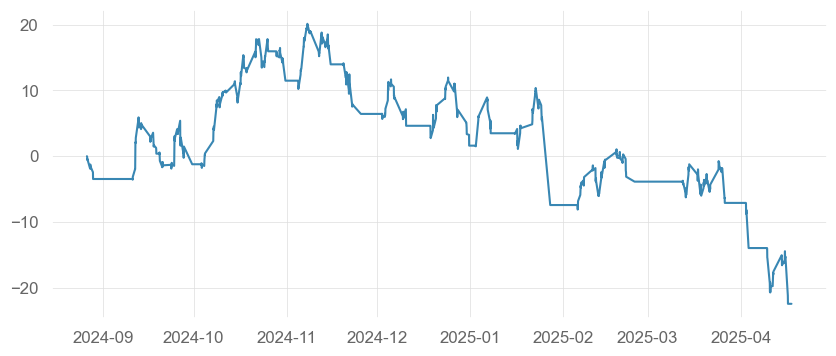

In [29]:
index_ta ,value_ta = visualizasion_portfolio_compound_return(port,label='Original Signal Stats',color='#3987b3')

<br>

<br>


#### Decision Tree 

In [30]:
dt_signal = pd.DataFrame(index=df_test.index)

dt_signal['Long_Entry'] = (df_test['ML_Signal_DT'] == 1)

dt_signal['Long_Entry'] = dt_signal['Long_Entry'].shift(1).fillna(False) 

In [31]:
# Step 4: ทำ Backtest ด้วย vectorbt โดยใช้สัญญาณ Entry และ Exit ที่ได้
port_dt = vbt.Portfolio.from_signals(
    open=df_test['Open'],  
    high=df_test['High'],
    low=df_test['Low'],
    close=df_test['Close'],
    entries=dt_signal['Long_Entry'],
    direction='longonly',
    init_cash=1000,
    fees=0.001,
    tp_stop=0.06,
    sl_stop=0.015
)

dt_portfolio_stats = pd.DataFrame(port_dt.stats(), columns=['DT Portfolio Stats'])
display(dt_portfolio_stats)

,DT Portfolio Stats
Start,2024-08-26 13:30:00+00:00
End,2025-04-17 19:30:00+00:00
Period,1126
Start Value,1000.0
End Value,1090.855796
Total Return [%],9.08558
Benchmark Return [%],-20.05203
Max Gross Exposure [%],100.0
Total Fees Paid,24.134716
Max Drawdown [%],9.476199


#### Visualization of Decision Tree & Trading Strategy (False Signal Detection) Compound Return

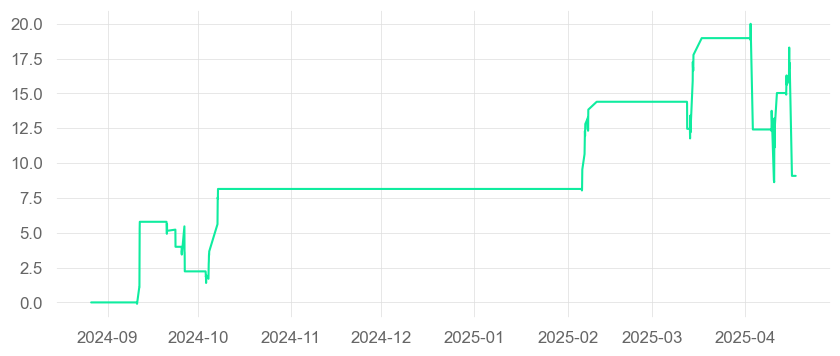

In [32]:
index_dt ,value_dt = visualizasion_portfolio_compound_return(port_dt,label='TA with Decision Tree False Signal Detection', color='#0fec9f')

<br>

#### Random Forest 

In [33]:
rf_signal = pd.DataFrame(index=df_test.index)

rf_signal['Long_Entry'] = (df_test['ML_Signal_RF'] == 1)

rf_signal['Long_Entry'] = rf_signal['Long_Entry'].shift(1).fillna(False)

In [34]:
port_rf = vbt.Portfolio.from_signals(
    open=df_test['Open'],
    high=df_test['High'],
    low=df_test['Low'],
    close=df_test['Close'],
    entries=rf_signal['Long_Entry'],
    direction='longonly',
    init_cash=1000,
    fees=0.001,
    tp_stop=0.06,
    sl_stop=0.015
)

rf_portfolio_stats = pd.DataFrame(port_rf.stats(), columns=['RF Portfolio Stats'])
display(rf_portfolio_stats)

,RF Portfolio Stats
Start,2024-08-26 13:30:00+00:00
End,2025-04-17 19:30:00+00:00
Period,1126
Start Value,1000.0
End Value,1167.002076
Total Return [%],16.700208
Benchmark Return [%],-20.05203
Max Gross Exposure [%],100.0
Total Fees Paid,18.140854
Max Drawdown [%],7.786648


#### Visualization of Random Forest & Trading Strategy (False Signal Detection) Compound Return

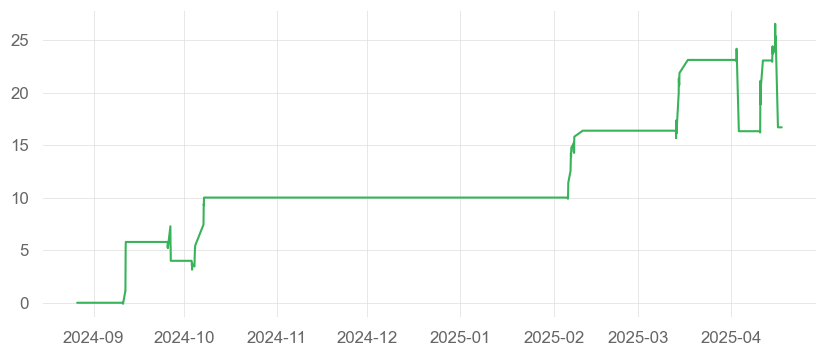

In [35]:
index_rf ,value_rf = visualizasion_portfolio_compound_return(port_rf,label='TA with RandomForest False Signal Detection', color='#39b359')

<br>

#### Visualization of Benchmark Compound Return

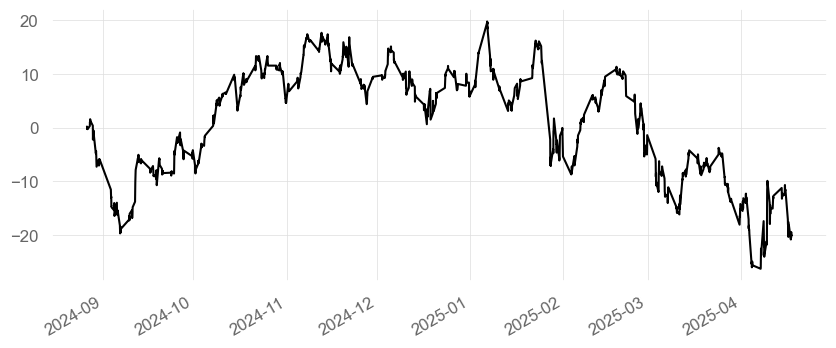

In [36]:
benchmark = df_test[['Close']][:]
benchmark_compound_return = (1+ benchmark.pct_change()).cumprod()-1
(benchmark_compound_return * 100).plot(figsize=(10, 4),color='black',legend=False)
plt.show()

<br>

<br>

<br>

<br>

<br>


### Summary Performance Evaluation ( Unseen data )

<br>

#### DataFrame

In [37]:
display(pd.concat([original_signal_stats,dt_portfolio_stats,rf_portfolio_stats],axis=1))

,Original Signal Stats,DT Portfolio Stats,RF Portfolio Stats
Start,2024-08-26 13:30:00+00:00,2024-08-26 13:30:00+00:00,2024-08-26 13:30:00+00:00
End,2025-04-17 19:30:00+00:00,2025-04-17 19:30:00+00:00,2025-04-17 19:30:00+00:00
Period,1126,1126,1126
Start Value,1000.0,1000.0,1000.0
End Value,775.462238,1090.855796,1167.002076
Total Return [%],-22.453776,9.08558,16.700208
Benchmark Return [%],-20.05203,-20.05203,-20.05203
Max Gross Exposure [%],100.0,100.0,100.0
Total Fees Paid,111.06946,24.134716,18.140854
Max Drawdown [%],35.453281,9.476199,7.786648


<br>

#### Visualization 

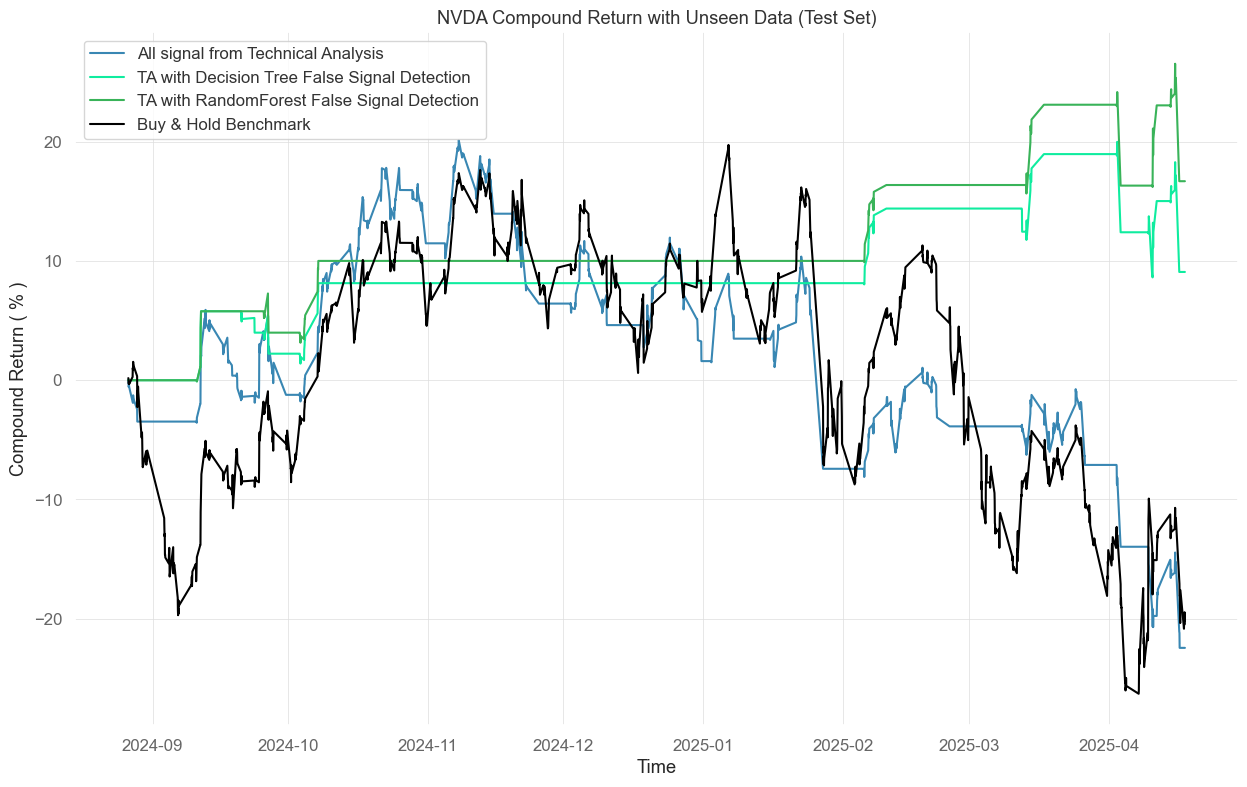

In [38]:
multiplier = 100

# Plot the compound return over time for both portfolios
plt.figure(figsize=(15, 9))

# Plot Technical Indicator Compound Return 
plt.plot(index_ta, value_ta*multiplier, label='All signal from Technical Analysis',color='#3987b3')

# Plot the ML Compound Return 
plt.plot(index_dt, value_dt*multiplier, label='TA with Decision Tree False Signal Detection', color='#0fec9f')


# Plot the ML Compound Return 
plt.plot(index_rf, value_rf*multiplier, label='TA with RandomForest False Signal Detection', color='#39b359')

plt.plot(benchmark_compound_return.index,benchmark_compound_return.values*multiplier, label='Buy & Hold Benchmark',color='black')

# Add labels and title
plt.title(f'{symbol} Compound Return with Unseen Data (Test Set)')
plt.xlabel('Time')
plt.ylabel('Compound Return ( % )')

# Add a legend to differentiate between the two portfolios
plt.legend()

# Add gridlines 
plt.grid(True)

# Show the plot
plt.show()

<br>

<br>


#### Important Feature 

<br>

##### From Decision Tree

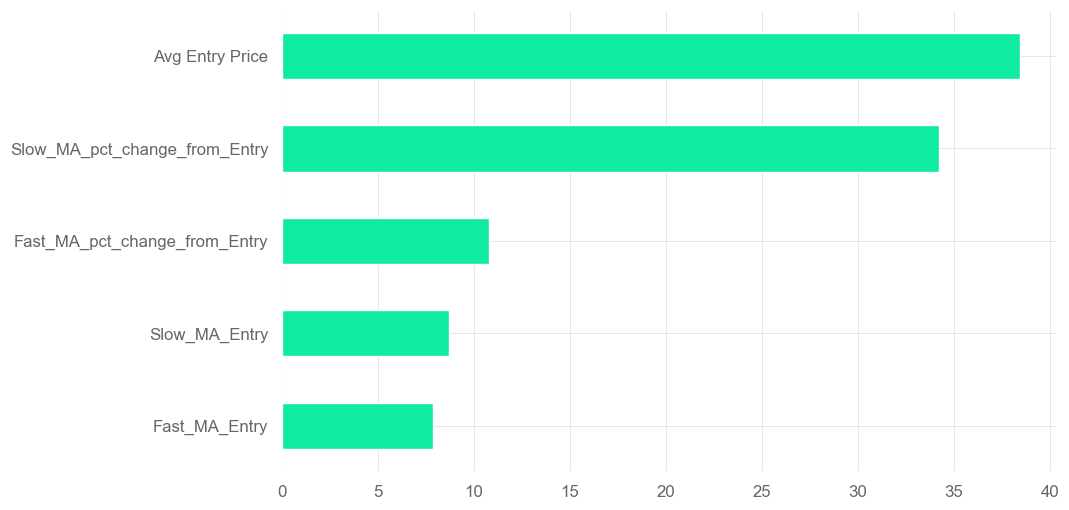

In [39]:
pd.Series(dt.feature_importances_ *multiplier, index=X.columns).sort_values().plot(kind='barh', color='#0fec9f')
plt.show()

<br>

##### From Random Forest

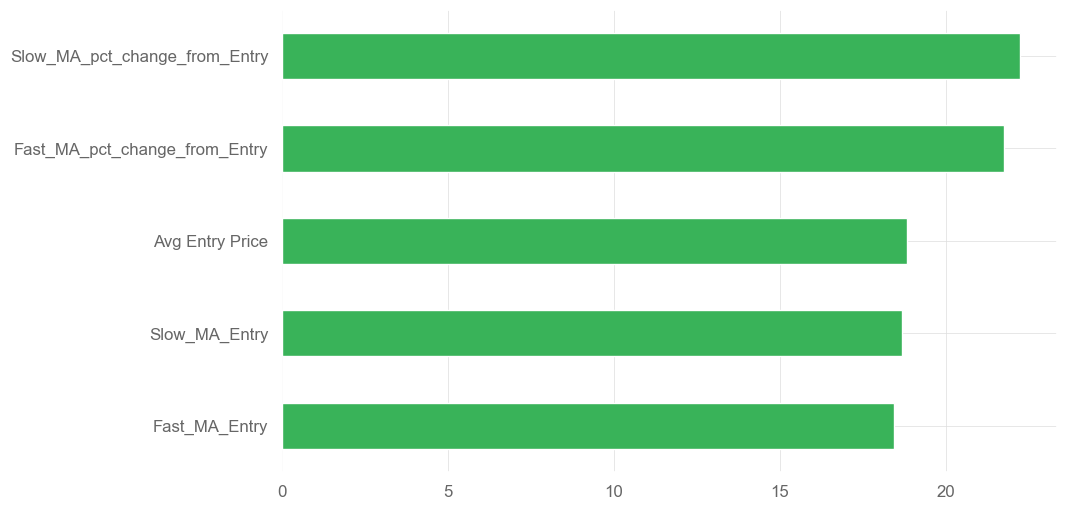

In [40]:
pd.Series(rf.feature_importances_ *multiplier, index=X.columns).sort_values().plot(kind='barh', color='#39b359')
plt.show()